# Part 1: Sentiment Analysis

In [ ]:
import pandas as pd

# Load the CSV file
file_path = './data/NEWS_YAHOO_stock_prediction.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataframe
data.head()

In [ ]:
# Step 1: Remove unnecessary column
data.drop(columns=['Unnamed: 0'], inplace=True)

# Step 2: Remove duplicate texts
data.drop_duplicates(subset=['title', 'content'], inplace=True)

# Step 3: Remove rows with large amount of spaces or empty texts in 'title' and 'content'
data = data[~data['title'].str.isspace()]
data = data[~data['content'].str.isspace()]
data.dropna(subset=['title', 'content'], inplace=True)

# Check the dataframe after these preprocessing steps
data.info()

# Step 5: Check for invalid numeric data
numeric_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
data[numeric_columns].describe()


In [ ]:
# (optional) set proxy
import subprocess
import os

result = subprocess.run('bash -c "source ~/clash_dir/set && env | grep proxy"', shell=True, capture_output=True, text=True)
output = result.stdout
output
for line in output.splitlines():
    if '=' in line:
        var, value = line.split('=', 1)
        os.environ[var] = value

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline

# Load the FinBERT model and tokenizer
checkpoint = 'yiyanghkust/finbert-tone'
tokenizer = BertTokenizer.from_pretrained(checkpoint)
model = BertForSequenceClassification.from_pretrained(checkpoint, num_labels=3)

# Create a pipeline for sentiment analysis
nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, max_length=512, truncation=True, device=0)

In [ ]:
# Function to apply sentiment analysis to a dataframe
def apply_sentiment_analysis(df, nlp, text_column='content'):
    """
    Apply sentiment analysis to a column in a dataframe.
    
    Args:
    df (pd.DataFrame): Dataframe containing the text data.
    nlp (pipeline): HuggingFace pipeline for sentiment analysis.
    text_column (str): Name of the column containing text data.

    Returns:
    pd.DataFrame: Dataframe with a new column 'sentiment' containing the analysis results.
    """
    # Apply sentiment analysis to each row in the text column
    sentiments = []
    for text in df[text_column]:
        try:
            result = nlp(text)
            sentiments.append(result[0]['label'])
        except Exception as e:
            print(f"Error in processing text: {e}")
            sentiments.append('Error')

    # Add the sentiments as a new column in the dataframe
    df['sentiment'] = sentiments
    return df


In [ ]:
from tqdm.auto import tqdm
import numpy as np
from concurrent.futures import ThreadPoolExecutor

def apply_sentiment_analysis_parallel(df, nlp, text_column='content', batch_size=10):
    """
    Apply sentiment analysis in parallel to a column in a dataframe.

    Args:
    df (pd.DataFrame): Dataframe containing the text data.
    nlp (pipeline): HuggingFace pipeline for sentiment analysis.
    text_column (str): Name of the column containing text data.
    batch_size (int): Number of texts to process in parallel.

    Returns:
    pd.DataFrame: Dataframe with a new column 'sentiment' containing the analysis results.
    """
    # Define a function to process a batch of texts
    def process_batch(texts):
        return [nlp(text)[0]['label'] for text in texts]

    # Break the texts into batches
    batches = [df[text_column][i:i + batch_size] for i in range(0, len(df), batch_size)]

    # Process batches in parallel
    sentiments = []
    with ThreadPoolExecutor() as executor:
        for batch_result in tqdm(executor.map(process_batch, batches), total=len(batches)):
            sentiments.extend(batch_result)

    # Add the sentiments as a new column in the dataframe
    df['sentiment'] = sentiments
    return df


In [ ]:
# Example usage of the function
# Note: You will run this on your local machine as it requires GPU support
sample_texts = ["I've been waiting for a HuggingFace course my whole life.", "So have I!"]
sample_df = pd.DataFrame(sample_texts, columns=['content'])
apply_sentiment_analysis(sample_df, nlp)

In [ ]:
# Assuming the apply_sentiment_analysis function is defined as shown previously

# Step 1: Apply sentiment analysis to the dataset
# This step should be done on your local machine due to the requirement of GPU support
data = apply_sentiment_analysis_parallel(data, nlp)

# Step 2: Prepare data for the prediction model
# Here we'll assume the sentiment analysis has been applied and 'sentiment' column is added to the data

# We might want to convert sentiments to numerical values for model training
sentiment_mapping = {'Positive': 1, 'Neutral': 0, 'Negative': -1}
data['sentiment_numeric'] = data['sentiment'].map(sentiment_mapping)

In [ ]:
# Example code to save the processed DataFrame to a CSV file
data.to_csv('./data/dataset_with_sentiment.csv', index=False)


In [ ]:
# Adjust display settings for better visualization of samples
pd.set_option('display.max_colwidth', 200)  # Adjust the width to fit longer texts

# Display some random samples with formatted output
sample_data = data.sample(n=10)[['content', 'sentiment']]

# Print each sample in a more readable format
for index, row in sample_data.iterrows():
    print(f"Sample {index}:")
    print(f"Content: {row['content']}")
    print(f"Sentiment: {row['sentiment']}\n")


In [ ]:
# Assuming 'data' is your DataFrame with 'sentiment' and 'label' columns
# Calculate the proportion of each sentiment category
sentiment_counts = data['sentiment'].value_counts(normalize=True) * 100

# Calculate the proportion of each label
label_counts = data['label'].value_counts(normalize=True) * 100

# Print the results
print("Sentiment Distribution (%):")
print(sentiment_counts)
print("\nLabel Distribution (%):")
print(label_counts)

# For additional insights, we can also look at the cross-tabulation of sentiment and label
crosstab = pd.crosstab(data['sentiment'], data['label'], normalize='index') * 100
print("\nCross-Tabulation of Sentiment and Label (%):")
print(crosstab)

In [ ]:
# read for existed csv
import pandas as pd
data = pd.read_csv('./data/dataset_with_sentiment.csv')

# Convert the 'Date' column to datetime format and sort the dataframe by 'Date'
data['Date'] = pd.to_datetime(data['Date'])
data_sorted = data.sort_values(by='Date')

In [ ]:
# 按 'Date' 和 'sentiment' 分组，然后计算每个类别的 category 为news和opinion的数量
category_news_per_day_sentiment = data_sorted[data_sorted['category'] == 'news'].groupby(['Date', 'sentiment']).size().unstack().fillna(0)
category_opinion_per_day_sentiment = data_sorted[data_sorted['category'] == 'opinion'].groupby(['Date', 'sentiment']).size().unstack().fillna(0)
# 分别计算news和opinion的total
category_news_total_per_day_sentiment = data_sorted[data_sorted['category'] == 'news'].groupby(['Date']).size()
category_opinion_total_per_day_sentiment = data_sorted[data_sorted['category'] == 'opinion'].groupby(['Date']).size()

data_sorted = data_sorted.set_index('Date')
data_sorted['P_news_pos'] = category_news_per_day_sentiment['Positive'].reindex(data_sorted.index) / category_news_total_per_day_sentiment.reindex(data_sorted.index)
data_sorted['P_news_neg'] = category_news_per_day_sentiment['Negative'].reindex(data_sorted.index) / category_news_total_per_day_sentiment.reindex(data_sorted.index)
data_sorted['P_op_pos'] = category_opinion_per_day_sentiment['Positive'].reindex(data_sorted.index) / category_opinion_total_per_day_sentiment.reindex(data_sorted.index)
data_sorted['P_op_neg'] = category_opinion_per_day_sentiment['Negative'].reindex(data_sorted.index) / category_opinion_total_per_day_sentiment.reindex(data_sorted.index)
data_sorted = data_sorted.reset_index()

In [ ]:
daily_data = data_sorted.groupby('Date').last()

# Shift the 'Open' column to get the next day's opening price
daily_data['Next_Open'] = daily_data['Open'].shift(-1)

# Drop the last row as it will not have a 'Next_Open' value
daily_data = daily_data[:-1]

In [ ]:
date_to_query = pd.to_datetime('2016-10-28')
daily_data.loc[(date_to_query)]

In [ ]:
date_to_query = pd.to_datetime('2016-10-28')
data_sorted.loc[data_sorted['Date'] == date_to_query]

In [ ]:
date_to_query = pd.to_datetime('2020-01-23')
daily_data.loc[(date_to_query)]

In [ ]:
date_to_query = pd.to_datetime('2018-05-06')
category_to_query = 'news'
data_sorted.loc[(data_sorted['Date'] == date_to_query) & (data_sorted['category'] == category_to_query)]

In [ ]:
daily_data['P_news_neg'].fillna(0, inplace=True)
daily_data['P_news_pos'].fillna(0, inplace=True)
daily_data['P_op_neg'].fillna(0, inplace=True)
daily_data['P_op_pos'].fillna(0, inplace=True)

In [ ]:
# 不直接删除，而是存到新的df中。保留'date'列
columns_to_keep = [col for col in daily_data.columns if col not in ['Next_Open','ticker', 'Adj Close', 'sentiment', 'sentiment_numeric', 'title', 'category', 'content', 'label']]
daily_data_selected = daily_data[columns_to_keep]
# 将'Date'列设置为daily_data_selected的索引，并将其排到第一位
daily_data_selected = daily_data_selected.reset_index()
daily_data_selected.set_index('Date', inplace=True)
daily_data_selected = daily_data_selected.sort_index()

In [ ]:
daily_data_selected.head(20)

In [ ]:
daily_data_selected.to_csv('./data/dataset_for_model.csv', index=True)

# Part 2: Stock price prediction

In [1]:
import pandas as pd
daily_data_selected = pd.read_csv('./data/dataset_for_model.csv')

In [2]:
# 选择特征和目标
# 保留原本的index，将'Date'列单独提取出来保存
date = daily_data_selected['Date']
features = daily_data_selected.drop(['Date','P_news_pos', 'P_news_neg', 'P_op_pos', 'P_op_neg'], axis=1)
# Open作为预测目标
target = daily_data_selected['Open']
features.tail()

,Open,High,Low,Close,Volume
1648,79.067497,79.684998,78.750000,79.682503,137816400
1649,79.297501,79.754997,79.000000,79.142502,110843200
1650,79.644997,79.997498,79.327499,79.425003,101832400
1651,79.480003,79.889999,78.912498,79.807503,104472000
1652,80.062500,80.832497,79.379997,79.577499,146537600


In [3]:
target.tail()

1648    79.067497
1649    79.297501
1650    79.644997
1651    79.480003
1652    80.062500
Name: Open, dtype: float64

In [4]:
# normalization
from sklearn.preprocessing import MinMaxScaler

# Apply the MinMaxScaler to the features and target
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

# fit_transform根据数据计算缩放参数
scaled_features = scaler_features.fit_transform(features)
scaled_target = scaler_target.fit_transform(target.values.reshape(-1, 1))

# 保存缩放参数
import joblib
joblib.dump(scaler_features, './model/scaler_features.pkl')
joblib.dump(scaler_target, './model/scaler_target.pkl')

# Create new DataFrames with the scaled features and target
scaled_features_df = pd.DataFrame(scaled_features, columns=features.columns)
scaled_target_df = pd.DataFrame(scaled_target, columns=['Open'])

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.dates as mdates

In [6]:
def create_sequences(features, targets, seq_length):
    """
    Create sequences of specified length from time series data.

    Args:
    features (np.array): The feature data.
    targets (np.array): The target data.
    seq_length (int): The length of the sequence.

    Returns:
    np.array: Sequences of features.
    np.array: Corresponding targets for each sequence.
    """
    xs, ys = [], []
    for i in range(len(features) - seq_length):
        x = features[i:(i + seq_length)]
        y = targets[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

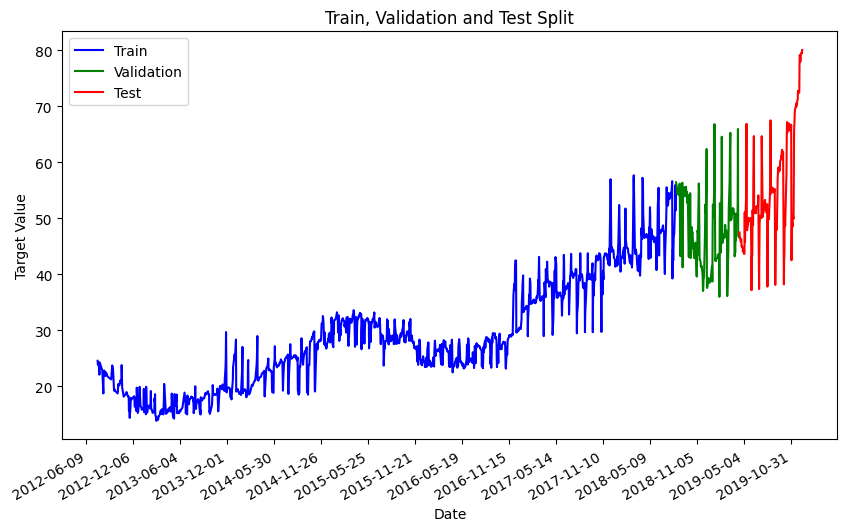

In [7]:
# Example sequence length
seq_length = 20

# Create sequences
features_seq, target_seq = create_sequences(scaled_features, scaled_target, seq_length)

# 计算训练集、验证集、测试集的大小
train_size = int(len(features_seq) * 0.9)
val_size = int(len(features_seq) * 0.05)
test_size = len(features_seq) - train_size - val_size

# 按时间顺序划分训练集、验证集、测试集
train_features, train_target = features_seq[:train_size], target_seq[:train_size]
val_features, val_target = features_seq[train_size:train_size+val_size], target_seq[train_size:train_size+val_size]
test_features, test_target = features_seq[train_size+val_size:], target_seq[train_size+val_size:]

# 假设我们的目标是预测第一个特征
train_target_unscaled = scaler_target.inverse_transform(train_target)
val_target_unscaled = scaler_target.inverse_transform(val_target)
test_target_unscaled = scaler_target.inverse_transform(test_target)

plt.figure(figsize=(10, 6))

# 将日期字符串转换为日期对象
date = pd.to_datetime(date)

# 绘制训练集
plt.plot(date[:train_size], train_target_unscaled, color='blue', label='Train')

# 绘制验证集
plt.plot(date[train_size:train_size+val_size], val_target_unscaled, color='green', label='Validation')

# 绘制测试集
plt.plot(date[train_size+val_size:train_size+val_size+len(test_target_unscaled)], test_target_unscaled, color='red', label='Test')

# 设置x轴的日期格式
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=180))  # 设置日期间隔，这里是每250天一个刻度

plt.title('Train, Validation and Test Split')
plt.xlabel('Date')
plt.ylabel('Target Value')
plt.legend()
plt.gcf().autofmt_xdate()  # 自动调整x轴日期标签的角度以提高可读性
plt.show()

In [8]:
# Convert sequences to Tensor
train_features = torch.tensor(train_features, dtype=torch.float32)
train_target = torch.tensor(train_target, dtype=torch.float32)

val_features = torch.tensor(val_features, dtype=torch.float32)
val_target = torch.tensor(val_target, dtype=torch.float32)

test_features = torch.tensor(test_features, dtype=torch.float32)
test_target = torch.tensor(test_target, dtype=torch.float32)

# 创建TensorDataset
train_dataset = TensorDataset(train_features, train_target)
val_dataset = TensorDataset(val_features, val_target)
test_dataset = TensorDataset(test_features, test_target)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [9]:
# 使用普通的LSTM模型，不使用注意力机制
class SimpleLSTM(nn.Module):
    def __init__(self, input_dim, hidden_size, num_layers, output_dim, dropout=0.2):
        super(SimpleLSTM, self).__init__()
        self.hidden_size = hidden_size

        # LSTM层
        self.lstm = nn.LSTM(input_dim, hidden_size, num_layers, 
                            batch_first=True, dropout=dropout if num_layers > 1 else 0)
        
        # 全连接层
        self.fc = nn.Linear(hidden_size, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        # 打印lstm_out的形状
        # print(lstm_out.shape)
        # 取最后一个时间步的输出
        output = self.fc(lstm_out[:, -1, :])
        return output

In [10]:
# 使用注意力机制的LSTM
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        self.attn = nn.Linear(self.hidden_size, 1)

    def forward(self, hidden, encoder_outputs):
        attn_weights = torch.tanh(self.attn(encoder_outputs))
        return torch.bmm(attn_weights.transpose(1, 2), encoder_outputs).squeeze(1)

class AttentionLSTM(nn.Module):
    def __init__(self, input_dim, hidden_size, num_layers, output_dim, dropout=0.2):
        super(AttentionLSTM, self).__init__()
        self.hidden_size = hidden_size

        # LSTM层
        self.lstm = nn.LSTM(input_dim, hidden_size, num_layers, 
                            batch_first=True, dropout=dropout if num_layers > 1 else 0)
        
        # 注意力层
        self.attention = Attention(hidden_size)
        
        # 全连接层
        self.fc = nn.Linear(hidden_size, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        attn_out = self.attention(lstm_out[:, -1, :], lstm_out)
        output = self.fc(attn_out)
        return output

In [11]:
# 超参数
input_dim = scaled_features_df.shape[1]  # 特征数量
hidden_size = 100  # 隐藏状态中的特征数量，可以调整
num_layers = 4    # 堆叠的LSTM层的数量
output_dim = 1    # 输出维度的数量（预测一个值）

# 使用SimpleLSTM
model = SimpleLSTM(input_dim, hidden_size, num_layers, output_dim)
# 使用AttentionLSTM
# model = AttentionLSTM(input_dim, hidden_size, num_layers, output_dim, dropout=0.2)

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_model updated at epoch 1, best_val_loss : 0.0082
Epoch 1/80, Train Loss: 0.0248, Validation Loss: 0.0082
best_model updated at epoch 2, best_val_loss : 0.0078
Epoch 6/80, Train Loss: 0.0020, Validation Loss: 0.0084
best_model updated at epoch 9, best_val_loss : 0.0078
Epoch 11/80, Train Loss: 0.0020, Validation Loss: 0.0083
best_model updated at epoch 14, best_val_loss : 0.0077
Epoch 16/80, Train Loss: 0.0017, Validation Loss: 0.0078
best_model updated at epoch 20, best_val_loss : 0.0075
best_model updated at epoch 21, best_val_loss : 0.0075
Epoch 21/80, Train Loss: 0.0018, Validation Loss: 0.0075
best_model updated at epoch 25, best_val_loss : 0.0068
Epoch 26/80, Train Loss: 0.0016, Validation Loss: 0.0069
best_model updated at epoch 27, best_val_loss : 0.0065
best_model updated at epoch 28, best_val_loss : 0.0064
Epoch 31/80, Train Loss: 0.0013, Validation Loss: 0.0077
best_model updated at epoch 32, best_val_loss : 0.0061
best_model updated at epoch 33, best_val_loss : 0.0058
b

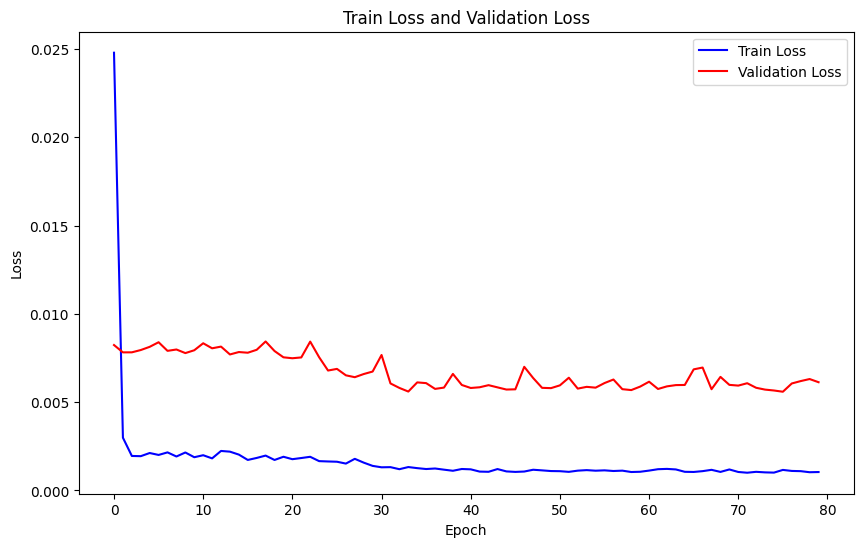

In [12]:
# 训练模型
num_epochs = 80
best_val_loss = float('inf')
train_loss_list = []
val_loss_list = []
for epoch in range(num_epochs):
    model.train()
    train_losses = []
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    model.eval()
    val_losses = []
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    # 保存最佳模型
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), './model/best_model.pth')
        print('best_model updated at epoch {}, best_val_loss : {:.4f}'.format(epoch+1, best_val_loss))
        
    # 每5轮打印一次train loss和val loss
    if epoch % 5 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

    # 记录两个loss
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    
# 在所有epochs结束后绘制损失图
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), train_loss_list, label='Train Loss', color='blue')
plt.plot(range(num_epochs), val_loss_list, label='Validation Loss', color='red')
plt.title('Train Loss and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [13]:
# 加载最佳模型
model.load_state_dict(torch.load('./model/best_model.pth'))

# 使用模型进行预测
model.eval()
with torch.no_grad():
    test_predictions = model(test_features).numpy()

import joblib
scaler_features = joblib.load('./model/scaler_features.pkl')
scaler_target = joblib.load('./model/scaler_target.pkl')

# 反缩放预测值
test_predictions = scaler_target.inverse_transform(test_predictions).flatten()

# 反缩放真实目标值
test_target = scaler_target.inverse_transform(test_target.reshape(-1, 1)).flatten()

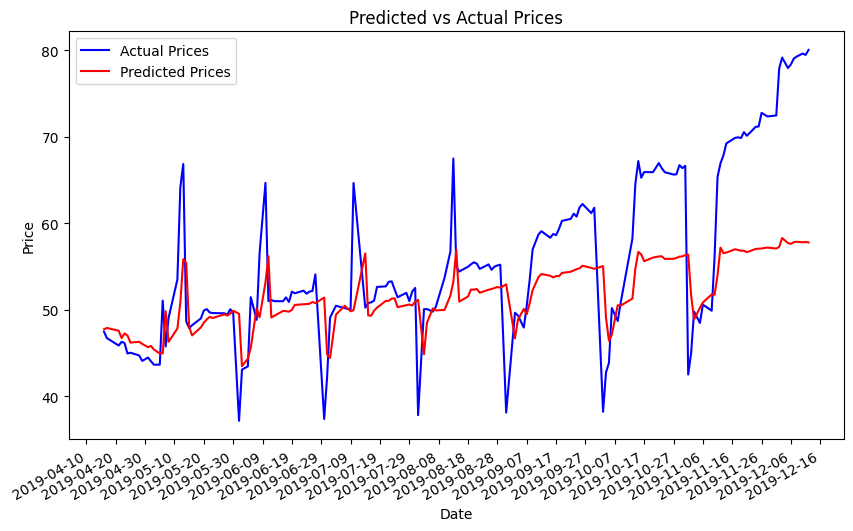

In [14]:
# 绘制实际股价和预测股价的对比图
plt.figure(figsize=(10, 6))
plt.plot(date[train_size+val_size:train_size+val_size+len(test_target)], test_target, label='Actual Prices', color='blue')
plt.plot(date[train_size+val_size:train_size+val_size+len(test_predictions)], test_predictions, label='Predicted Prices', color='red')

# 设置x轴的日期格式
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))  # 设置日期间隔，这里是每180天一个刻度

plt.title('Predicted vs Actual Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.gcf().autofmt_xdate()  # 自动调整x轴日期标签的角度以提高可读性
plt.show()

In [15]:
from sklearn.metrics import mean_squared_error

# 计算MSE
mse = mean_squared_error(test_target, test_predictions)
print('Test MSE: ', mse)
# 计算RMSE
rmse = np.sqrt(mse)
print('Test RMSE: ', rmse)

Test MSE:  69.27458044399731
Test RMSE:  8.32313525325627
